# Random Acts of Pizza

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

https://www.kaggle.com/c/random-acts-of-pizza

## 1. Load Packages and Data

In [57]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import random
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Put data in "Data" folder which is in the same location as this notebook
os.getcwd()
os.chdir('Data')
os.getcwd()
#os.chdir('C:\Users\zolotab\Desktop\w207-Machine-Learning-Final-Project-master\w207-Machine-Learning-Final-Project-master\Data')

'C:\\Users\\mpowers\\Documents\\Berkeley\\W207 Machine Learning\\Assignments\\Final Project\\Data'

In [58]:
# load data from json files to df
with open('train.json') as fin:
    trainjson = json.load(fin)

with open('test.json') as fin:
    testjson = json.load(fin)
    
df_train = pd.io.json.json_normalize(trainjson)
df_test = pd.io.json.json_normalize(testjson)

In [59]:
# Review columns
df_train.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

Data dictionary:

"giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

"number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

"number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

"post_was_edited": Boolean indicating whether this post was edited (from Reddit).

"request_id": Identifier of the post on Reddit, e.g. "t3_w5491".

"request_number_of_comments_at_retrieval": Number of comments for the request at time of retrieval.

"request_text": Full text of the request.

"request_text_edit_aware": Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

"request_title": Title of the request.

"requester_account_age_in_days_at_request": Account age of requester in days at time of request.

"requester_account_age_in_days_at_retrieval": Account age of requester in days at time of retrieval.

"requester_days_since_first_post_on_raop_at_request": Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP).

"requester_days_since_first_post_on_raop_at_retrieval": Number of days between requesters first post on RAOP and time of retrieval.

"requester_number_of_comments_at_request": Total number of comments on Reddit by requester at time of request.

"requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

"requester_number_of_comments_in_raop_at_request": Total number of comments in RAOP by requester at time of request.

"requester_number_of_comments_in_raop_at_retrieval": Total number of comments in RAOP by requester at time of retrieval.

"requester_number_of_posts_at_request": Total number of posts on Reddit by requester at time of request.

"requester_number_of_posts_at_retrieval": Total number of posts on Reddit by requester at time of retrieval.

"requester_number_of_posts_on_raop_at_request": Total number of posts in RAOP by requester at time of request.

"requester_number_of_posts_on_raop_at_retrieval": Total number of posts in RAOP by requester at time of retrieval.

"requester_number_of_subreddits_at_request": The number of subreddits in which the author had already posted in at the time of request.

"requester_received_pizza": Boolean indicating the success of the request, i.e., whether the requester received pizza.

"requester_subreddits_at_request": The list of subreddits in which the author had already posted in at the time of request.

"requester_upvotes_minus_downvotes_at_request": Difference of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_minus_downvotes_at_retrieval": Difference of total upvotes and total downvotes of requester at time of retrieval.

"requester_upvotes_plus_downvotes_at_request": Sum of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_plus_downvotes_at_retrieval": Sum of total upvotes and total downvotes of requester at time of retrieval.

"requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

"requester_username": Reddit username of requester.

"unix_timestamp_of_request": Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

"unix_timestamp_of_request_utc": Unit timestamp of request in UTC.

**Conclusion: The outcome variable requester_received_pizza indicates if the user received pizza or not. The explanatory variables we are interested in using are free text fields that contain the title and text of the written request, as well as other numeric and datetime metadata fields.**

## 2. Exploratory Data Analysis

In [60]:
# Do all of the records contain request text?
print(len(df_train[df_train['request_text']==""]))
print(len(df_train[df_train['request_text_edit_aware']==""]))
print(len(df_train[df_train['request_title']==""]))
print(df_train['request_text_edit_aware'].isnull().sum())
print(df_train['request_title'].isnull().sum())
 # All of the records have a title. Sometimes a request is made only using a title.
 # This suggests that we should plan to concatentate the request title and text.

104
104
0
0
0


In [53]:
#PLACEHOLDER: Lets list the percentage of missing or blank values for all of the numeric features below,
#as well as the request text and title



####

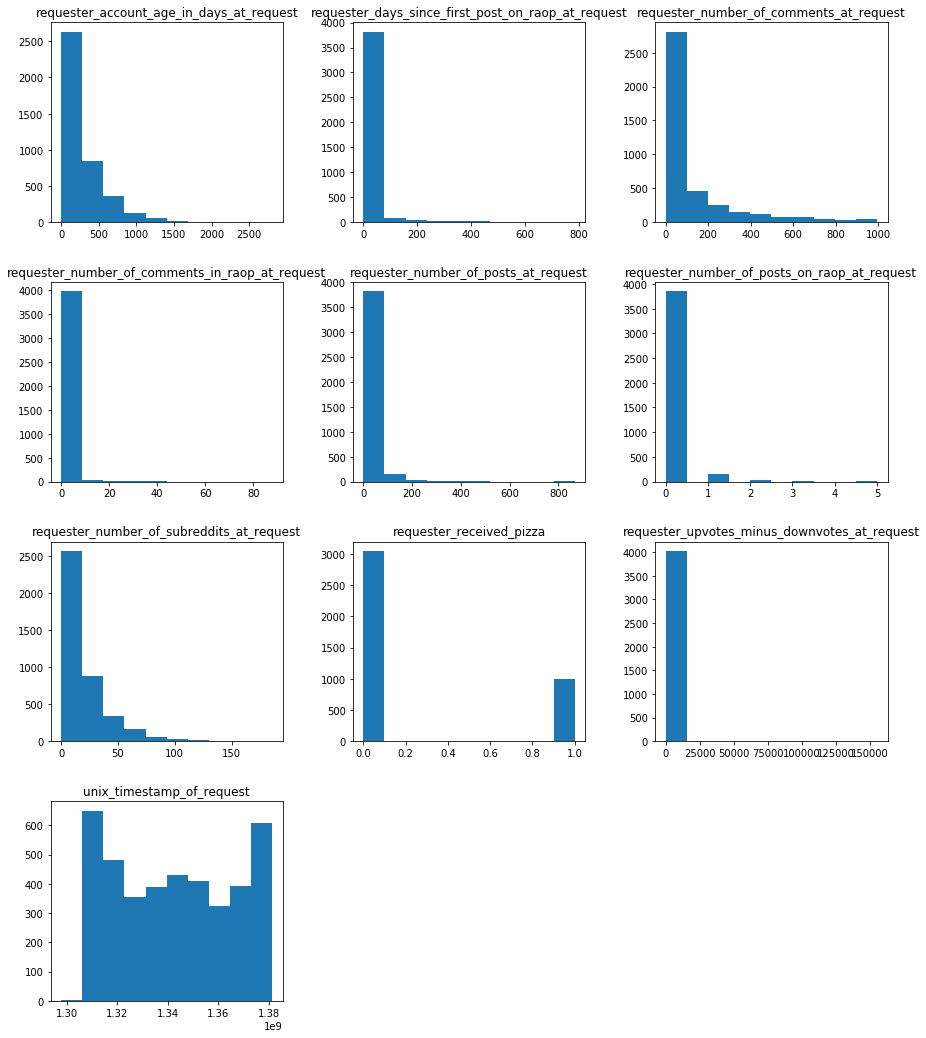

In [61]:
# Histograms of numeric variables
numeric_features = [
'requester_received_pizza',
'requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request', 
'requester_number_of_comments_at_request', 
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request', 
'requester_upvotes_minus_downvotes_at_request', 
'unix_timestamp_of_request']

hist = df_train[numeric_features].hist(grid=False, layout=(4,3), figsize=(15,18))

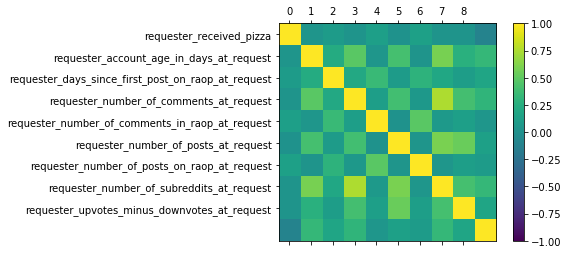

In [62]:
# Correlations
correlations = df_train[numeric_features].corr()

# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(numeric_features)
ax.set_yticklabels(numeric_features)
plt.show()

In [54]:
# Scatter plot matrix
from pandas import scatter_matrix

# MP Note: This doesn't work for me
# bsm = scatter_matrix(train_data[numeric_features], alpha=0.2, figsize=(20, 20), diagonal='kde')

**Conclusion: None of the numeric metadata seems to be correlated with the outcome variable (requester_received_pizza). Most of the distributions appear to be exponential. (Placeholder: comment about missing values)**

## 3. Data Preparation

**Split data sets into train/dev/test. Since the test data does not indicate whether a pizza was received, we will split the training data in order to obtain a labeled test set.**

In [63]:
# randomize and split data set into train test and dev using 60/20/20 split
random.seed(33)
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train_data, df_train_labels = df_train.ix[shuffle, :], df_train.ix[shuffle, 'requester_received_pizza']
#df_train_data, df_train_labels = df_train, df_train['requester_received_pizza']

# Set some variables to test, dev and training data
cutoff1 = int(df_train_labels.shape[0]*0.6)
cutoff2 = int(df_train_labels.shape[0]*0.8)
train_data, train_labels = df_train_data[:cutoff1], df_train_labels[:cutoff1]
dev_data, dev_labels = df_train_data[cutoff1:cutoff2], df_train_labels[cutoff1:cutoff2]
test_mini_data, test_mini_labels = df_train_data[cutoff2:], df_train_labels[cutoff2:]

print ('train data shape: ', train_data.shape)
print ('dev data shape:', dev_data.shape)
print ('test data shape:', test_mini_data.shape)

train data shape:  (2424, 32)
dev data shape: (808, 32)
test data shape: (808, 32)


## 4. Predictive Modeling

### 4.1 Vectorizing the Request Text

In [64]:
vectorizer = CountVectorizer()
train_data_nlp = vectorizer.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp = vectorizer.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp = vectorizer.transform(test_mini_data['request_text_edit_aware'])

In [65]:
print("Size of the vocabulary:")
print(train_data_nlp.shape[1])

Size of the vocabulary:
9396


##### K Nearest Neighbors Model

In [66]:
k_values = {"n_neighbors": list(range(1,10))}
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=k_values)
knn_gs.fit(dev_data_nlp, dev_labels)

knn_clf_best = KNeighborsClassifier(n_neighbors=knn_gs.best_params_['n_neighbors'])
knn_clf_best.fit(train_data_nlp, train_labels)
knn_clf_best_predicted = knn_clf_best.predict(test_mini_data_nlp)

print('----- K Nearest Neighbors -----')
print (knn_gs.best_params_)
print ("KNN accuracy:", accuracy_score(knn_clf_best_predicted, test_mini_labels) * 100)

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, knn_clf_best_predicted))
print('-----------------------------------')

----- K Nearest Neighbors -----
{'n_neighbors': 8}
KNN accuracy: 75.12376237623762
Confusion matrix:
[[603   9]
 [192   4]]
-----------------------------------


##### Multinomial Naive Bayes Model

In [67]:
# Multinomial modeling

alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print ("Multinomial accuracy:", accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 1.5}
Multinomial accuracy: 74.62871287128714
Confusion matrix:
[[602  10]
 [195   1]]
-----------------------------------


##### Logistic Regression Model

In [68]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy:", accuracy_score(log_clf_best_predicted, test_mini_labels) * 100)

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 75.74257425742574
Confusion matrix:
[[612   0]
 [196   0]]
-----------------------------------


**Conclusion: We attempted different models using a basic count vectorizor on the raw request text. Next, we will attempt to improve this by taking steps to clean the request text in order to potentially obtain a more useful dictionary and word counts.**

### 4.2 Advanced Count Vectorizer

In [27]:
# # ***** RUN THIS ONCE *****

# # Downloading corpus of stopwords and other functions

# nltk.download()

In [69]:
# Removing stopwords and punctuations

from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

stopwords_en = set(stopwords.words('english'))

# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [70]:
# Removing stemming and lemmatization

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

# tagging part of speech so that lemmatization can be done
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [71]:
# updated preprocessor

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    # Convert all text to lowercase
    text = text.lower()
    
    # Replace sequences of numbers with a single token
    text = re.sub(r'\d+','numseq',text)
    
    # Remove non letter characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]



In [72]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_text_edit_aware'])

In [73]:
print("Size of the vocabulary:")
print(train_data_nlp2.shape[1])

Size of the vocabulary:
7152


##### Multinomial Naive Bayes Model

In [74]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print("Multinomial accuracy:", accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100)

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted will get pizza:',sum(multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 1}
Multinomial accuracy: 72.4009900990099
Number of predictions: 808
Number predicted will get pizza: 41
-----------------------------------


##### Logistic Regression Model

In [75]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy:", accuracy_score(log_clf_best_predicted, test_mini_labels) * 100)

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 75.74257425742574
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


**Conclusion: This did not really change or improve results. Next, we suspect the request title may have useful information as well. We saw in our EDA that some requests did not have request text, but all of them had a title, which means some people made their complete request using the title only.**

### 4.3 Advanced Count Vectorizer Using Request Text and Title

In [76]:
# Create field that concatenates the request text and title in case the title contains more predictive power
train_data['request_title_and_text'] = train_data['request_title'] + ' ' + train_data['request_text_edit_aware']
dev_data['request_title_and_text'] = dev_data['request_title'] + ' ' + dev_data['request_text_edit_aware']
test_mini_data['request_title_and_text'] = test_mini_data['request_title'] + ' ' + test_mini_data['request_text_edit_aware']

In [77]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_title_and_text'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_title_and_text'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_title_and_text'])

In [78]:
print("Size of the vocabulary:")
print(train_data_nlp2.shape[1])

Size of the vocabulary:
7834


##### Multinomial Naive Bayes Model

In [88]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)

accuracy = accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100
print ('Multinomial accuracy: {:2.5f}%'.format(accuracy))

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted will get pizza:',sum(multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 5}
Multinomial accuracy: 75.74257%
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


##### Logistic Regression Model

In [87]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.5f}%'.format(accuracy))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 75.74257%
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


**Conclusion: Simply vectorizing the words does not provide much predictive power, which is why most of our models based on word counts are predicting that most people will not get pizza. Next, we will attempt to engineer features from the text, and look at the other numeric metadata.**

### 4.4 Analyze Numeric Metadata Features + Engineered Features from Request Text

In [81]:
# Feature engineering ideas:

# 1. length of request - number of characters
train_data['request_len'] = train_data['request_title_and_text'].str.len()
dev_data['request_len'] = dev_data['request_title_and_text'].str.len()
test_mini_data['request_len'] = test_mini_data['request_title_and_text'].str.len()

# 2. Month of request (rather than timestamp)
train_data['request_month'] = train_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
dev_data['request_month'] = dev_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
test_mini_data['request_month'] = test_mini_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)

# 3. Day of week - i.e. maybe people are more likely to get pizza on friday rather than monday?
train_data['request_dayofweek'] = train_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())
dev_data['request_dayofweek'] = dev_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())
test_mini_data['request_dayofweek'] = test_mini_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())

# 4. Does request contain an image? (.jpeg, etc.)
imagelist = ['.tif','.gif','.jpeg','.jpg','.jif','.png','.pdf']
train_data['contains_image'] = np.where(any(word in train_data['request_title_and_text'] for word in imagelist), 1, 0)
dev_data['contains_image'] = np.where(any(word in dev_data['request_title_and_text'] for word in imagelist), 1, 0)
test_mini_data['contains_image'] = np.where(any(word in test_mini_data['request_title_and_text'] for word in imagelist), 1, 0)

# 5. Sentiment score

# 6. Turn our count vectorizer above into PCA compontents (maybe 10 components?)


In [82]:
numeric_features = [
'requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request', 
'requester_number_of_comments_at_request', 
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request', 
'requester_upvotes_minus_downvotes_at_request', 
'request_len',
'request_month',
'request_dayofweek',
'contains_image']

##### Random Forests Model

In [83]:
# Random Forest
def randomForestClassifier(x_train, y_train, x_test, y_test, grid = 0):
    
    if grid == 1:
        
        parameters = { 
            'n_estimators' : list(np.arange(1000, 10000, 3000)),
            'max_leaf_nodes' : list(np.arange(10, 100, 30)),
            'criterion' : ['gini', 'entropy']
        }

        # perform gridsearch
        rnd_clf = GridSearchCV(RandomForestClassifier(), parameters)
        rnd_clf.fit(x_train, y_train)

        n_estimators = rnd_clf.best_params_['n_estimators']
        max_leaf_nodes = rnd_clf.best_params_['max_leaf_nodes']
        criterion = rnd_clf.best_params_['criterion']

        clf = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, criterion=criterion)
        
    else:
        
        clf = RandomForestClassifier()
        
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0

    print ('Accuracy: {:2.5f}%'.format(accuracy))
    return y_pred

In [84]:
# Execute random forest model without gridsearch
print('----- Random Forests -----')
y_pred = randomForestClassifier(train_data[numeric_features],train_labels,
                                test_mini_data[numeric_features],test_mini_labels,grid=0)
print('Number of predictions:', len(y_pred))
print('Number predicted will get pizza:',sum(y_pred))
print('--------------------------')

----- Random Forests -----
Accuracy: 72.52475%
Number of predictions: 808
Number predicted will get pizza: 72
--------------------------


In [74]:
# Execute random forest model with gridsearch. (Run time approximately 10 minutes)
# print(datetime.datetime.now())
# randomForestClassifier(train_data[numeric_features],train_labels,test_mini_data[numeric_features],test_mini_labels,grid=1)
# print(datetime.datetime.now())

2018-07-25 15:03:42.695119
Accuracy: 76.23762%
2018-07-25 15:13:01.622495


##### Logistic Regression Model

In [86]:
# Logisitic modeling - numeric features
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data[numeric_features], dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data[numeric_features], train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data[numeric_features])

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.5f}%'.format(accuracy))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.5}
Logistic accuracy: 75.61881%
Number of predictions: 808
Number predicted will get pizza: 29
-----------------------------------
